# Taipei Diabetes Prediction (Project 2)
This notebook follows the project instructions: exploratory data analysis, feature engineering, model training/comparison, evaluation on a hold-out set, model export, and a simple web app endpoint.


## How to use this notebook
- (Optional) install dependencies inside your environment: pandas, numpy, scikit-learn, matplotlib, seaborn, joblib, streamlit.
- Run cells in order; artifacts are saved under `artifacts/` for reuse by the web app.
- The dataset file `TAIPEI_diabetes.csv` must stay in the repo root.


In [27]:
# Uncomment the line below if you need to install packages in a fresh environment
# !pip install -q pandas numpy scikit-learn matplotlib seaborn joblib streamlit



In [28]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import joblib

SEED = 42
sns.set_theme(style="ticks")


## Load and preview the dataset
- The dataset comes from Taipei Municipal medical center (2018-2022) and contains 15,000 female patients.
- The target column is `Diabetic` (1 = diabetes diagnosed, 0 = no diabetes).
- All features are numeric; `PatientID` is dropped before modeling.


In [29]:
DATA_PATH = Path("TAIPEI_diabetes.csv")

raw_df = pd.read_csv(DATA_PATH).dropna(how="all")
print(f"Raw shape: {raw_df.shape}")
raw_df.head()


Raw shape: (15000, 10)


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [30]:
# Basic info and quick statistics
raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [31]:
raw_df.describe()


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


## Data cleaning and feature preparation
Steps:
1. Drop identifier columns (they do not help prediction).
2. Cast numeric columns to floats/ints and coerce bad values to NaN.
3. Replace physiologically impossible zeros with NaN for selected fields.
4. Keep the target column as integer labels.


In [32]:
TARGET = "Diabetic"
ID_COLS = ["PatientID"]
FEATURES = [
    "Pregnancies",
    "PlasmaGlucose",
    "DiastolicBloodPressure",
    "TricepsThickness",
    "SerumInsulin",
    "BMI",
    "DiabetesPedigree",
    "Age",
]
ZERO_AS_MISSING = [
    "PlasmaGlucose",
    "DiastolicBloodPressure",
    "TricepsThickness",
    "SerumInsulin",
    "BMI",
]

# Drop identifiers and enforce numeric types
clean_df = raw_df.drop(columns=ID_COLS, errors="ignore").copy()
clean_df[FEATURES + [TARGET]] = clean_df[FEATURES + [TARGET]].apply(pd.to_numeric, errors="coerce")
clean_df[TARGET] = clean_df[TARGET].astype("Int64")

# Mark zeros as missing for columns where zero is not physiologically valid
clean_df[ZERO_AS_MISSING] = clean_df[ZERO_AS_MISSING].replace(0, np.nan)

# Remove rows with missing target labels
clean_df = clean_df.dropna(subset=[TARGET])
print(clean_df[[TARGET]].value_counts(normalize=True) * 100)
clean_df.head()


Diabetic
0           66.666667
1           33.333333
Name: proportion, dtype: float64


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,0,171,80,34,23,43.509726,1.213191,21,0
1,8,92,93,47,36,21.240576,0.158365,23,0
2,7,115,47,52,35,41.511523,0.079019,23,0
3,9,103,78,25,304,29.582192,1.282870,43,1
4,1,85,59,27,35,42.604536,0.549542,22,0


In [33]:
# Missing value summary per feature
missing_summary = (
    clean_df[FEATURES]
    .isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda x: (x["missing_count"] / len(clean_df) * 100).round(2))
)
missing_summary


,missing_count,missing_pct
Pregnancies,0,0.0
PlasmaGlucose,0,0.0
DiastolicBloodPressure,0,0.0
TricepsThickness,0,0.0
SerumInsulin,0,0.0
BMI,0,0.0
DiabetesPedigree,0,0.0
Age,0,0.0


# EDA

In [34]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pregnancies             15000 non-null  int64  
 1   PlasmaGlucose           15000 non-null  int64  
 2   DiastolicBloodPressure  15000 non-null  int64  
 3   TricepsThickness        15000 non-null  int64  
 4   SerumInsulin            15000 non-null  int64  
 5   BMI                     15000 non-null  float64
 6   DiabetesPedigree        15000 non-null  float64
 7   Age                     15000 non-null  int64  
 8   Diabetic                15000 non-null  Int64  
dtypes: Int64(1), float64(2), int64(6)
memory usage: 1.0 MB


In [35]:
clean_df.duplicated().sum()

0

In [36]:
print("Showing the number of rows and columns of the dataset:")
clean_df.shape

Showing the number of rows and columns of the dataset:


(15000, 9)

In [37]:
print("Showing first 5rows of the dataset:")
clean_df.head()

Showing first 5rows of the dataset:


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,0,171,80,34,23,43.509726,1.213191,21,0
1,8,92,93,47,36,21.240576,0.158365,23,0
2,7,115,47,52,35,41.511523,0.079019,23,0
3,9,103,78,25,304,29.582192,1.282870,43,1
4,1,85,59,27,35,42.604536,0.549542,22,0


In [38]:
print("Summary Statistics of Dataset:")
clean_df.describe()

Summary Statistics of Dataset:


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.0
mean,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.47142
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.0
25%,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.0
50%,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.0
75%,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.0
max,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.0


In [39]:
print("Missing Values in Dataset:\n")
print(clean_df.isnull().sum())

Missing Values in Dataset:

Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64


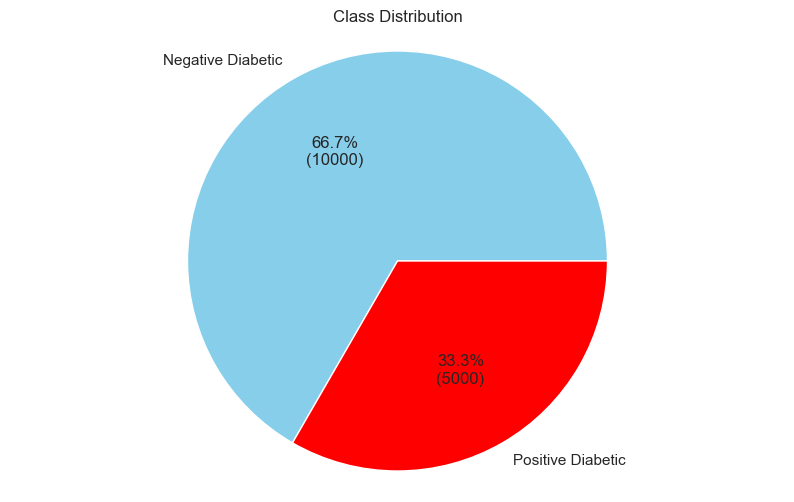

In [40]:
class_distribution = clean_df['Diabetic'].value_counts()

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return my_format

plt.figure(figsize=(10, 6))
plt.pie(
    class_distribution,
    labels=['Negative Diabetic', 'Positive Diabetic'],
    autopct=autopct_format(class_distribution),
    colors=['skyblue', 'red']
)

plt.title('Class Distribution')
plt.axis('equal')
plt.show()

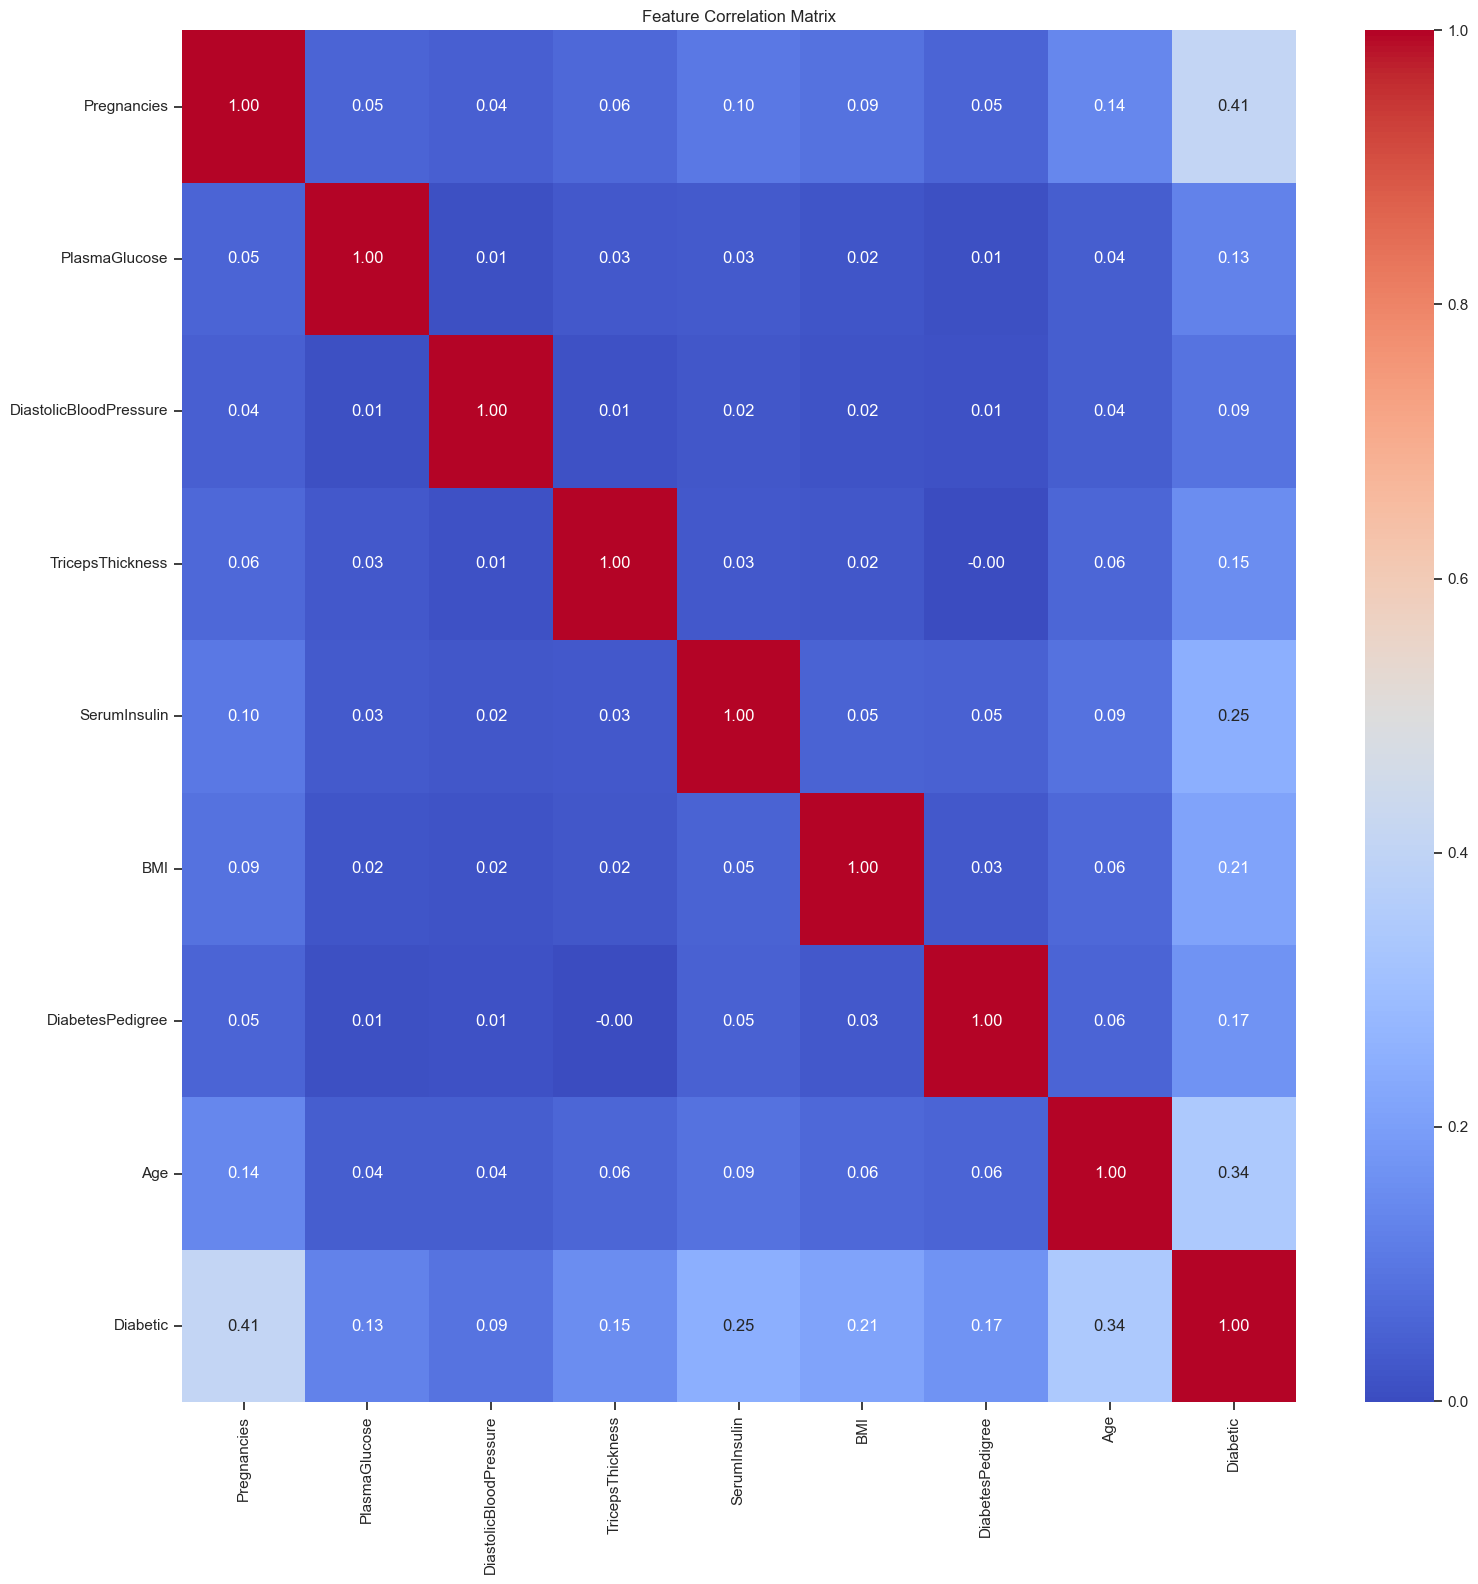

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation
correlation_matrix = clean_df.corr()

# Plot
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Feature Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

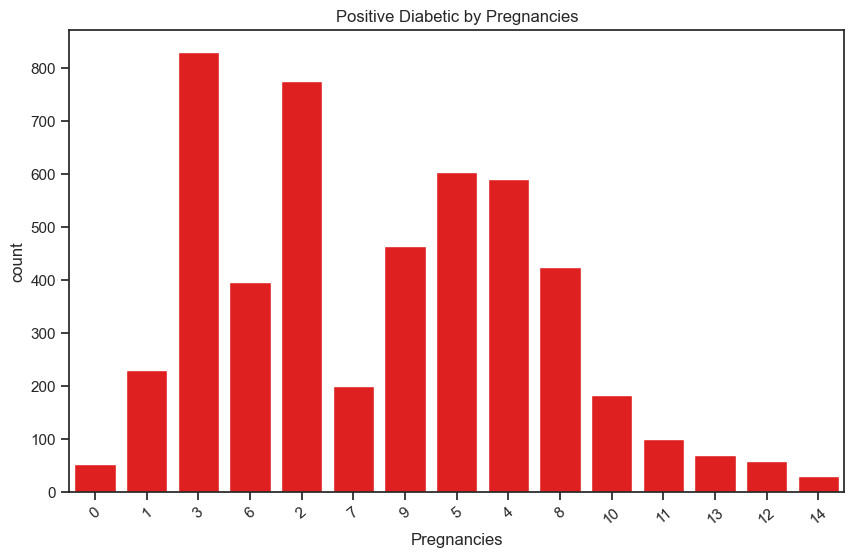

In [42]:
# Positive Diabetic by Pregnancies
plt.figure(figsize=(10, 6))
sns.countplot(x='Pregnancies', data=clean_df[clean_df['Diabetic'] == 1], color="red", order=clean_df['Pregnancies'].value_counts().index)
plt.title("Positive Diabetic by Pregnancies")
plt.xticks(rotation=40)
plt.show()

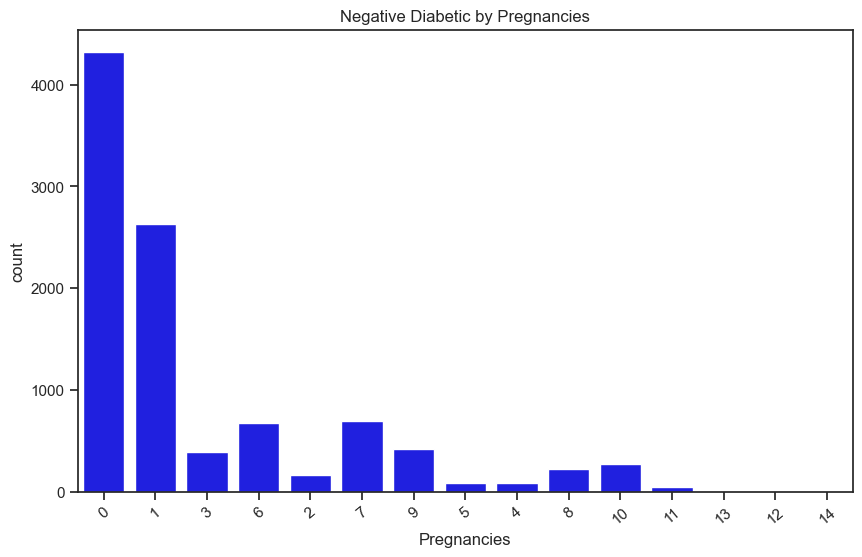

In [43]:
# Negative Diabetic by Pregnancies
plt.figure(figsize=(10, 6))
sns.countplot(x='Pregnancies', data=clean_df[clean_df['Diabetic'] == 0], color="blue", order=clean_df['Pregnancies'].value_counts().index)
plt.title("Negative Diabetic by Pregnancies")
plt.xticks(rotation=40)
plt.show()

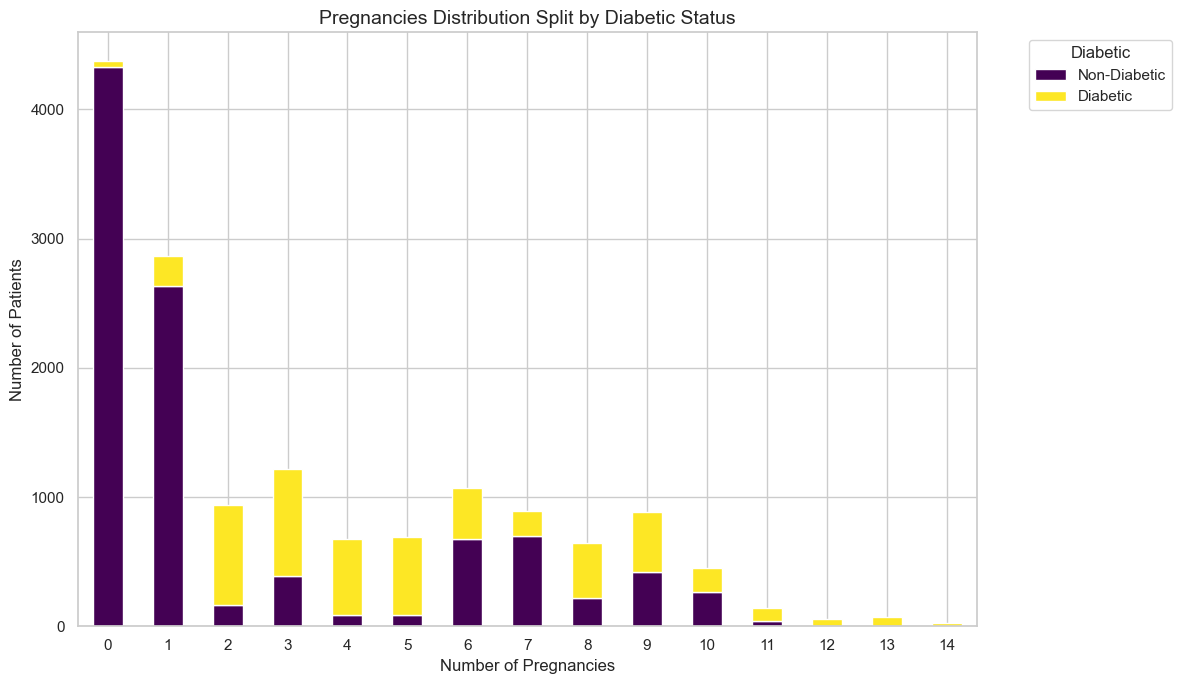

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data
grouped_data = (
    clean_df.groupby(['Pregnancies', 'Diabetic'])
    .size()
    .reset_index(name='Count')
)

# Pivot for stacked bar
pivot_data = grouped_data.pivot(
    index='Pregnancies',
    columns='Diabetic',
    values='Count'
).fillna(0)

# Plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

pivot_data.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap='viridis'
)

plt.title('Pregnancies Distribution Split by Diabetic Status', fontsize=14)
plt.xlabel('Number of Pregnancies', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=0)

plt.legend(
    title='Diabetic',
    labels=['Non-Diabetic', 'Diabetic'],
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_26928\2712531189.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clean_df.groupby(['Age_Group', 'Diabetic'])


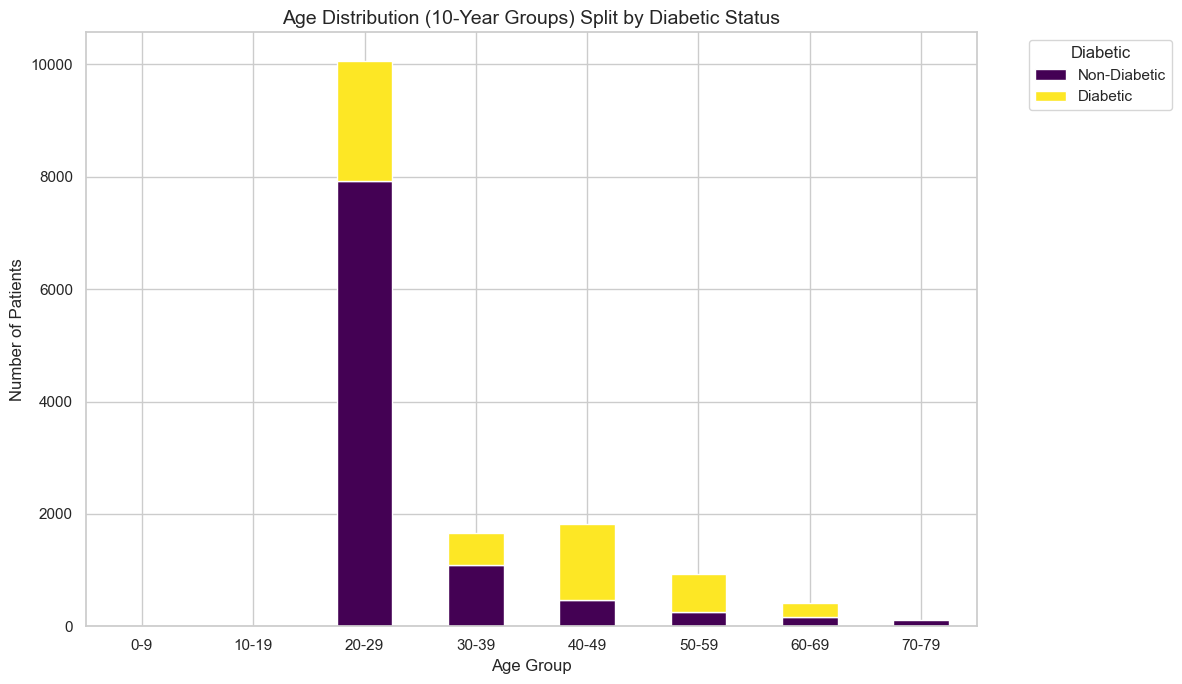

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create 10-year age bins
bins = range(0, clean_df['Age'].max() + 10, 10)
labels = [f'{i}-{i+9}' for i in bins[:-1]]

clean_df['Age_Group'] = pd.cut(clean_df['Age'], bins=bins, labels=labels, right=False)

# Group data
grouped_data = (
    clean_df.groupby(['Age_Group', 'Diabetic'])
    .size()
    .reset_index(name='Count')
)

# Pivot for stacked bar chart
pivot_data = grouped_data.pivot(
    index='Age_Group',
    columns='Diabetic',
    values='Count'
).fillna(0)

# Plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

pivot_data.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap='viridis'
)

plt.title('Age Distribution (10-Year Groups) Split by Diabetic Status', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=0)

plt.legend(
    title='Diabetic',
    labels=['Non-Diabetic', 'Diabetic'],
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()

## Train/validation split and preprocessing pipeline
- Stratified train/test split to preserve target balance.
- ColumnTransformer to handle numeric imputation and scaling.


In [46]:
X = clean_df[FEATURES]
y = clean_df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=SEED,
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, FEATURES)],
    remainder="drop",
)


## Model selection with cross-validation
Compare 4 models on the training split. Metrics: accuracy, precision, recall, F1, accuracy.


In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = ["accuracy", "precision", "recall", "f1"]

candidates = {
    "Logistic_Regression": LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=-1),
    "random_forest": RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        random_state=SEED,
        class_weight="balanced",
        n_jobs=-1,
    ),
    "Gradient_Boosting": GradientBoostingClassifier(random_state=SEED),
    "knn": KNeighborsClassifier(n_neighbors=15),}

cv_rows = []
for name, model in candidates.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("clf", model),
    ])
    cv_result = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )
    cv_rows.append(
        {
            "model": name,
            "accuracy": cv_result["test_accuracy"].mean(),
            "precision": cv_result["test_precision"].mean(),
            "recall": cv_result["test_recall"].mean(),
            "f1": cv_result["test_f1"].mean(),
        }
    )

cv_scores = pd.DataFrame(cv_rows).sort_values("accuracy", ascending=False).reset_index(drop=True)
cv_scores


,model,accuracy,precision,recall,f1
0,Gradient_Boosting,0.948917,0.928511,0.91750,0.922923
1,random_forest,0.937917,0.922908,0.88800,0.905101
2,knn,0.865667,0.830419,0.75025,0.788264
3,Logistic_Regression,0.773500,0.631945,0.76775,0.693237


Pick the model with the highest accuracy (ties broken by F1). Train it on the full training split and evaluate on the hold-out test set.


In [48]:
# Identify best model
best_row = cv_scores.sort_values(["accuracy", "f1"], ascending=False).iloc[0]
best_name = best_row["model"]
best_estimator = candidates[best_name]
print(f"Selected model: {best_name}")

best_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", best_estimator),
])

best_pipeline.fit(X_train, y_train)

# Test evaluation
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
}
metrics


Selected model: Gradient_Boosting


{'accuracy': 0.9483333333333334,
 'precision': 0.9289340101522843,
 'recall': 0.915,
 'f1': 0.9219143576826196}

In [49]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2000
           1       0.93      0.92      0.92      1000

    accuracy                           0.95      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.95      0.95      0.95      3000



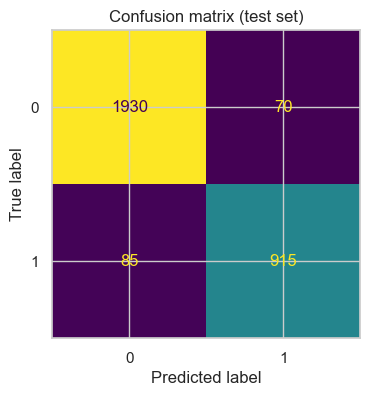

In [50]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)
ax.set_title("Confusion matrix (test set)")
plt.show()



## Persist the best model
Save the trained pipeline (preprocessing + classifier) so the web app can load it for inference.


In [51]:
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)
model_path = ARTIFACT_DIR / "best_diabetes_model.joblib"
joblib.dump(best_pipeline, model_path)
model_path


WindowsPath('artifacts/best_diabetes_model.joblib')

In [54]:
# Inspect the saved model
loaded_model = joblib.load(model_path)
print("Loaded model type:", type(loaded_model))
print("Classifier type:", type(loaded_model.named_steps['clf']))
print("Classifier name:", loaded_model.named_steps['clf'].__class__.__name__)

Loaded model type: <class 'sklearn.pipeline.Pipeline'>
Classifier type: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Classifier name: GradientBoostingClassifier
